In [1]:
import re, time
from tqdm import tqdm_notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

pj_dir = Path(os.getcwd()).parents[0]
data_dir = pj_dir/'data'
img_dir = pj_dir/'images'
src_dir = pj_dir/'src'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook
from dotenv import load_dotenv

In [14]:
import japanize_matplotlib

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
os.listdir(data_dir)

['rebuildfm.csv']

In [145]:
df = pd.read_csv(data_dir/'rebuildfm.csv')

In [146]:
df.head()

,date,persons,record_time,shownotes,title
0,Feb 13-2013,"['naoya', 'miyagawa']",52:53,"['5by5,', 'Mule Radio', 'Instapaper for Androi...","1: Podcasting, LTSV, RubyMotion (伊藤直也)"
1,Feb 20-2013,"['kenn', 'miyagawa']",47:56,"['Macbook Pro, Air update', 'Crashplan', 'Arq'...","2: Rails, Redis, VPS (Kenn Ejima)"
2,Feb 27-2013,"['frsyuki', 'kiyoto', 'miyagawa']",40:39,[],"3: MessagePack (frsyuki, kiyoto)"
3,Mar 06-2013,"['satoru', 'miyagawa']",31:04,[],"4: bkノート, Yak Shaving, Code Reviews (高林哲)"
4,Mar 13-2013,"['matz', 'miyagawa']",35:12,"['Ruby 20周年', 'Ruby 2.0.0-p0 released', 'COOKP...",5: Ruby 2.0 (まつもとゆきひろ)


In [147]:
df['date'] = pd.to_datetime(df['date'])

In [148]:
df['persons'] = df['persons'].apply(ast.literal_eval)

In [149]:
df['shownotes'] = df['shownotes'].apply(ast.literal_eval)

In [150]:
n_shownotes = []
for i, row in df.iterrows():
    n_s = len(row['shownotes'])
    n_shownotes.append(n_s)

In [151]:
df['n_shownotes'] = n_shownotes

In [152]:
hours = df['record_time'].str.extract('(?<=^)(\d)(?=:)').fillna(0).astype(int)
minutes = df['record_time'].str.extract('(\d\d)(?=:)') .fillna(0).astype(int)
seconds = df['record_time'].str.extract('(?<=\d\d)(\d\d)(?=$)') .fillna(0).astype(int)

In [153]:
df['minutes'] = hours*60 + minutes + seconds/60

In [154]:
def plot_hist(s, title, bins=30):
        fig = plt.figure(figsize=(16, 4))
        ax = fig.add_subplot(1, 1, 1)

        mean =s.mean().round(2)
        median = s.median().round(2)

        ax = s.hist(bins=bins, color="C0", density=True, ax=ax)
        ax.set_title(title, fontsize=20)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
        ax.text( 0.99, 0.99, f"平均値: {mean:.2f} \n 中央値: {median:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

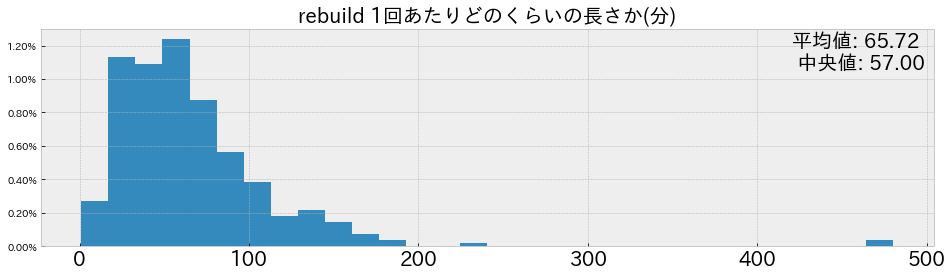

In [155]:
plot_hist(df['minutes'], 'rebuild 1回あたりどのくらいの長さか(分)')

Text(0,0.5,'')

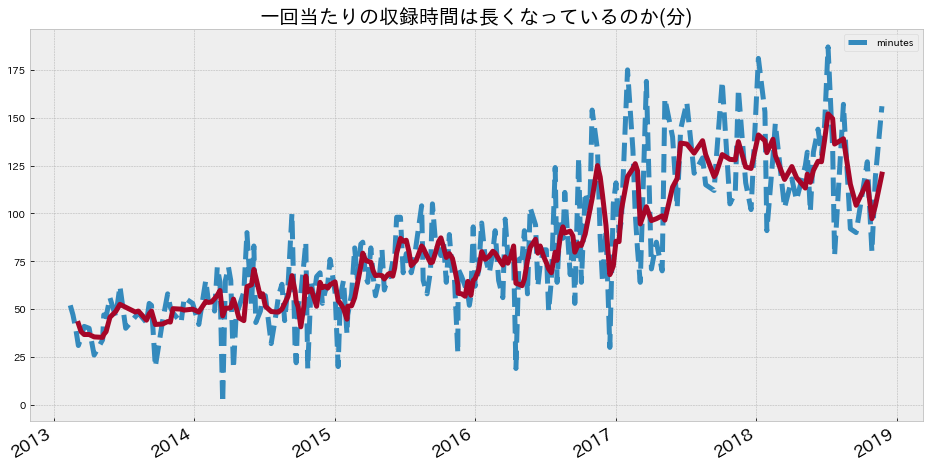

In [78]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
df.plot('date', 'minutes', linewidth=5, linestyle='--', ax=ax)
df.set_index('date')['minutes'].rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('一回当たりの収録時間は長くなっているのか(分)', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

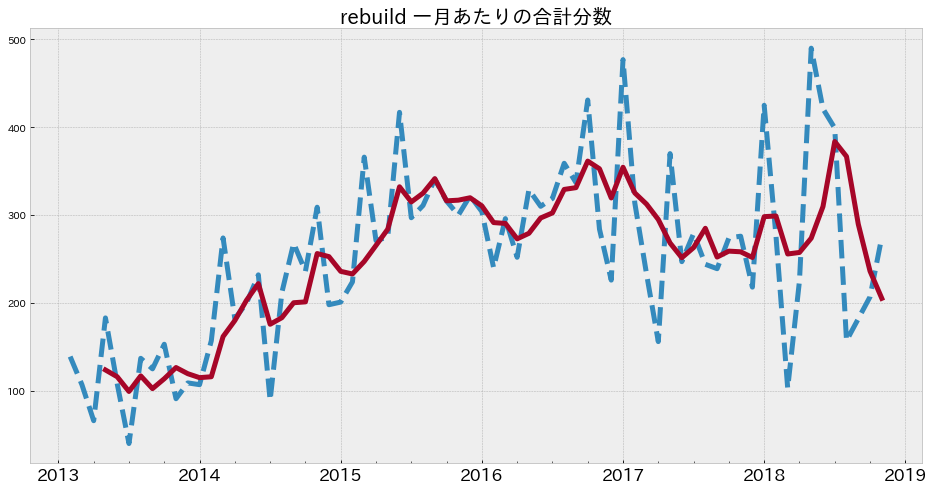

In [76]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax = df.groupby(pd.Grouper(key='date', freq='1M'))['minutes'].sum().plot(linewidth=5, linestyle='--', ax=ax)
ax = df.groupby(pd.Grouper(key='date', freq='1M'))['minutes'].sum().rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('rebuild 一月あたりの合計分数', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

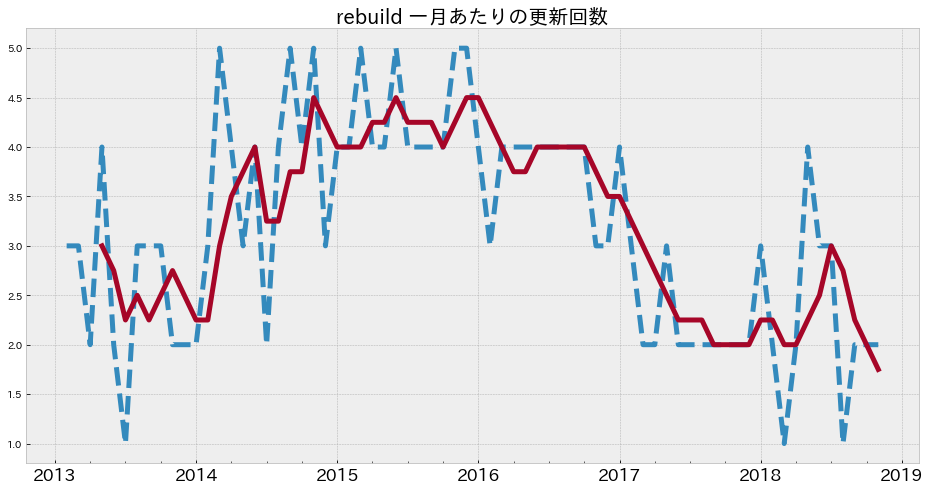

In [77]:
fig = plt.figure(figsize=(16, 8))
ax = df.groupby(pd.Grouper(key='date', freq='1M')).size().plot(linewidth=5, linestyle='--')
ax = df.groupby(pd.Grouper(key='date', freq='1M')).size().rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('rebuild 一月あたりの更新回数', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [26]:
persons = []
for i, row in df.iterrows():
    tmp_persosn = ast.literal_eval(row['persons'])
    persons.extend(tmp_persosn)

In [27]:
s_persons = pd.Series(persons)

In [28]:
s_persons = s_persons[s_persons != 'miyagawa']

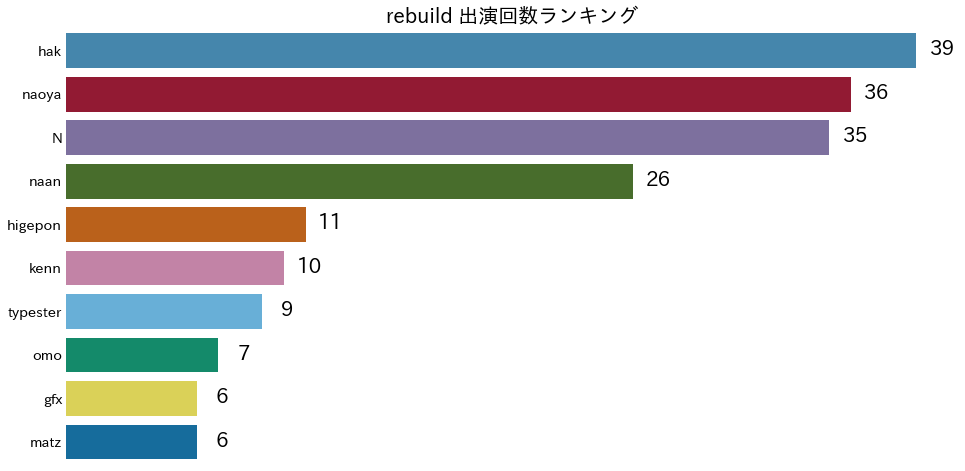

In [29]:
fig = plt.figure(figsize=(16,8))
# fig.patch.set_facecolor('white')

tmp_df = s_persons.value_counts()[:10].to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('rebuild 出演回数ランキング', fontsize=20)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

In [80]:
shownotes = []
for i, row in df.iterrows():
    tmp_shownote = row['shownotes']
    shownotes.extend(tmp_shownote)
s_shownotes = pd.Series(shownotes)

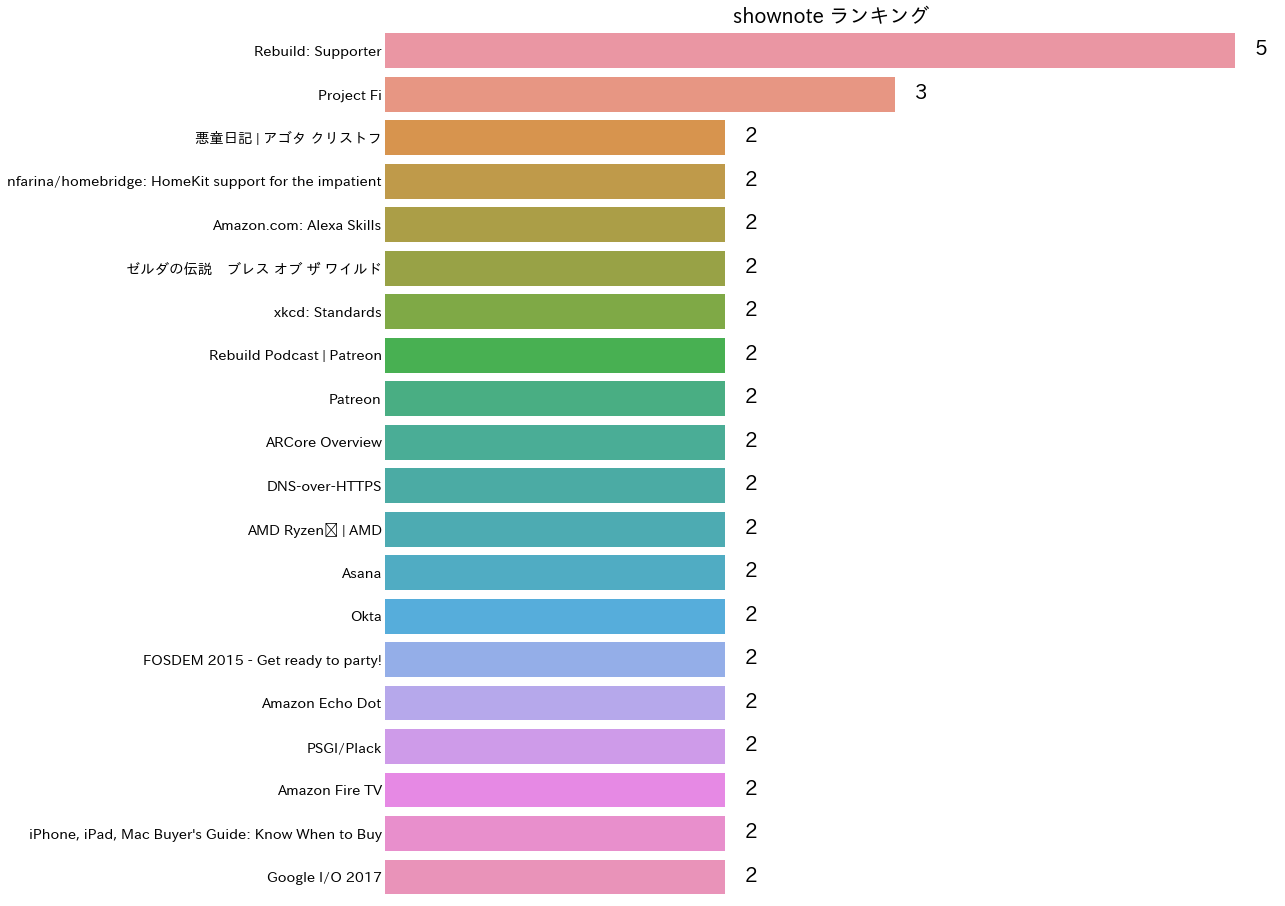

In [83]:
plt.figure(figsize=(16,16))

tmp_df = s_shownotes.value_counts()[:20].to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('shownote ランキング', fontsize=20)

ax.patch.set_alpha(0)
plt.grid(False)

In [121]:
ignore_word = ['-', '–', 'to', 'for', 'the', 'and', '|', 'in', 'of', 'a', 'is', 'on', 'with', 'how', 'new', 'by', '2', 'at', 'rebuild:']

In [122]:
shownotes_split = []
for i, row in df.iterrows():
    tmp_shownote = row['shownotes']
    for t in tmp_shownote:
        tmp_split = t.split()
        shownotes_split.extend(tmp_split)
shownotes_split = [s for s in shownotes_split if s.lower() not in ignore_word]
s_shownotes_split = pd.Series(shownotes_split)

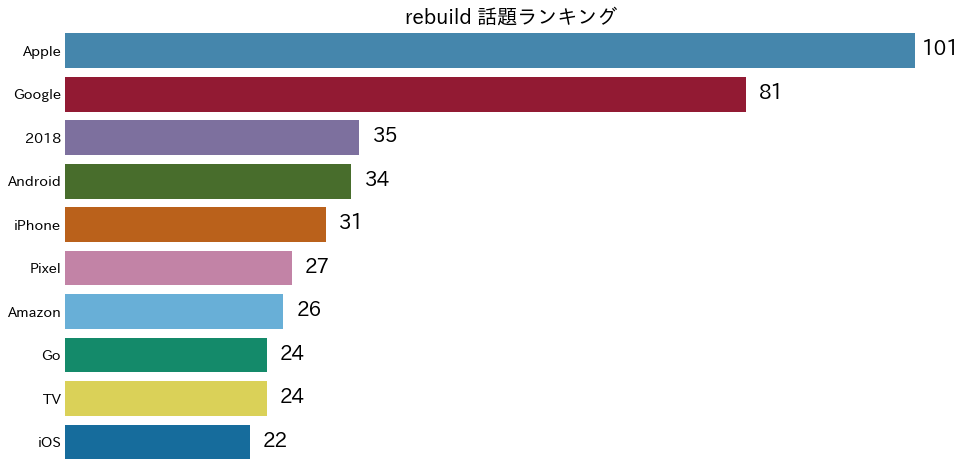

In [142]:
plt.figure(figsize=(16,8))

tmp_df = s_shownotes_split.value_counts()[:10].to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('rebuild 話題ランキング', fontsize=20)

ax.patch.set_alpha(0)
ax.patch.set_facecolor('white') 
plt.grid(False)

In [35]:
from copy import deepcopy

In [119]:
ls_dfs = []
for i, row in df.iterrows():
    persons = row['persons']
    for p in persons:
        new_row = deepcopy(row)
        new_row['person'] = p
        ls_dfs.append(new_row)

In [120]:
dfs = pd.DataFrame(ls_dfs)

In [121]:
top10_speaker = s_persons.value_counts()[:10].index.tolist()

Text(0,0.5,'')

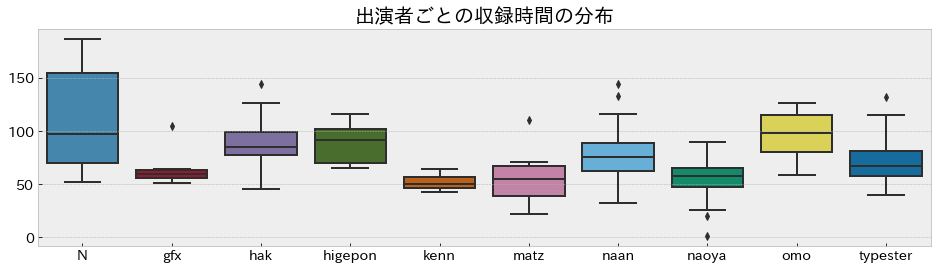

In [125]:
ax = sns.boxplot(data=dfs.query('person in @top10_speaker').sort_values('person'), x='person', y='minutes')
ax.set_title('出演者ごとの収録時間の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [136]:
dfs['is_aftershow'] = False
dfs['is_aftershow'] = dfs['is_aftershow'].mask(dfs['title'].str.contains('Aftershow', na=False), True)

In [141]:
dfs.tail()

,date,persons,record_time,shownotes,title,minutes,n_shownotes,person,is_aftershow
219,2018-10-28,"[hak, miyagawa]",1:20:48,"[Fastly Yamagoya Meetup 2018, Deckset for Mac,...",220: Graceless Shutdown (hak),80,17,miyagawa,False
220,2018-11-06,"[basuke, miyagawa]",1:59:20,"[Apple Events - Keynote October 2018, Meet the...",221: Something's Plugged Into His iPad (basuke),119,17,basuke,False
220,2018-11-06,"[basuke, miyagawa]",1:59:20,"[Apple Events - Keynote October 2018, Meet the...",221: Something's Plugged Into His iPad (basuke),119,17,miyagawa,False
221,2018-11-23,"[N, miyagawa]",2:36:07,"[California fires, Customizing the Infograph f...",222: UPS Pickup Friendship (N),156,14,N,False
221,2018-11-23,"[N, miyagawa]",2:36:07,"[California fires, Customizing the Infograph f...",222: UPS Pickup Friendship (N),156,14,miyagawa,False


In [140]:
dfs[dfs['title'].str.contains('After', na=False)]

,date,persons,record_time,shownotes,title,minutes,n_shownotes,person,is_aftershow
14,2013-07-07,"[typester, miyagawa]",40:20,[],"15: After Google Reader, DIY Blogging, The Go ...",40,0,typester,False
14,2013-07-07,"[typester, miyagawa]",40:20,[],"15: After Google Reader, DIY Blogging, The Go ...",40,0,miyagawa,False
63,2014-10-23,"[hotchpotch, miyagawa]",19:02,[],64: Web+DB Press Vol.83 Aftershow (hotchpotch),19,0,hotchpotch,True
63,2014-10-23,"[hotchpotch, miyagawa]",19:02,[],64: Web+DB Press Vol.83 Aftershow (hotchpotch),19,0,miyagawa,True
100,2015-07-19,"[dice, miyagawa]",1:09:50,[],101: Before And After Refactoring (Dice),69,0,dice,False
100,2015-07-19,"[dice, miyagawa]",1:09:50,[],101: Before And After Refactoring (Dice),69,0,miyagawa,False


In [137]:
dfs['is_aftershow'].value_counts()

False    478
True       2
Name: is_aftershow, dtype: int64

Text(0,0.5,'')

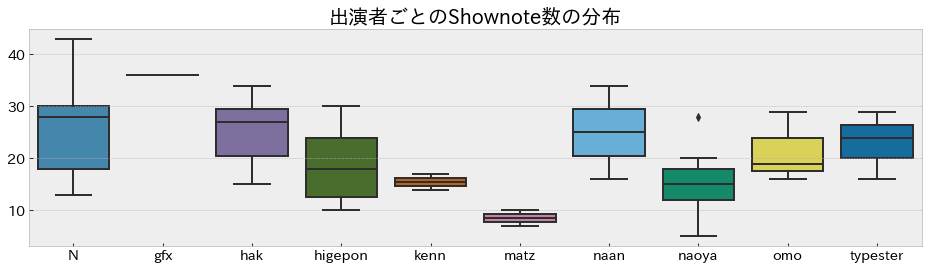

In [126]:
ax = sns.boxplot(data=dfs.query('n_shownotes > 0').query('person in @top10_speaker').sort_values('person'), x='person', y='n_shownotes')
ax.set_title('出演者ごとのShownote数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [95]:
pieoption = {'pctdistance': 0.3, 'autopct': "%1.1f%%", 'startangle': 90, 'counterclock': False,  'labeldistance': 0.6,  'textprops': {'color': "white", 'weight': "bold", 'fontsize': 12}}

In [96]:
df['minutes'].sum()

17538

In [97]:
17538/60

292.3

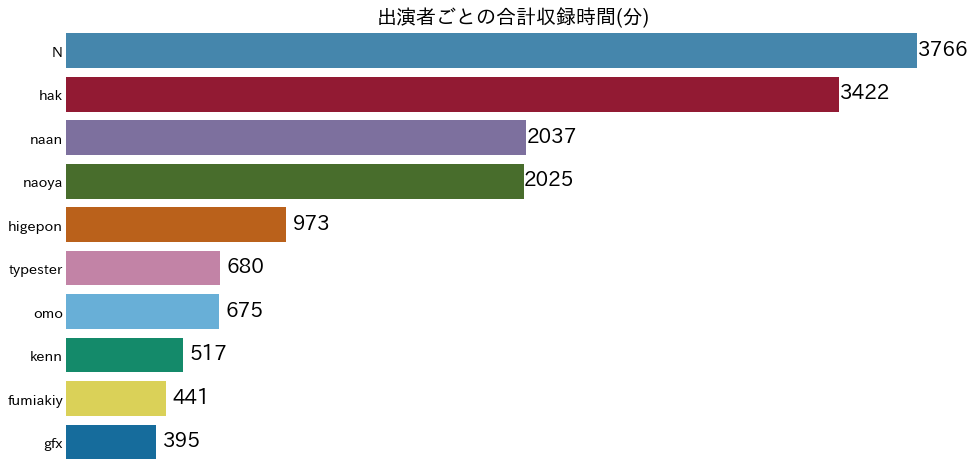

In [114]:
plt.figure(figsize=(16,8))

tmp_df = dfs.groupby('person')['minutes'].sum().sort_values(ascending=False)[1:11].to_frame('value').reset_index().rename(columns={'person': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('出演者ごとの合計収録時間(分)', fontsize=20)

ax.patch.set_alpha(0)
plt.grid(False)

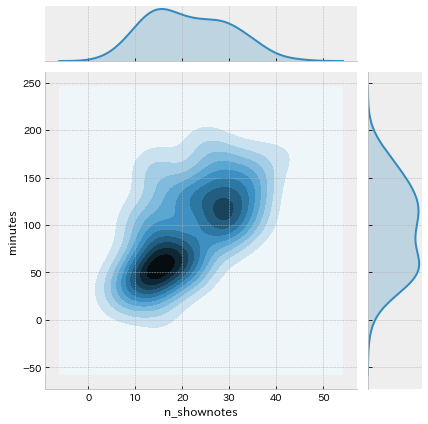

In [128]:
sns.jointplot("n_shownotes", "minutes", data=df.query('n_shownotes > 0'), kind="kde")